In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import math as math


In [2]:
def func(X):
    return -torch.sin(6*math.pi*X)**2+6*X**2-5*X**4+3/2

# Data
X = torch.tensor(np.linspace(0, 1, 30))
y = func(X)

class CombinedKernel(gp.kernels.Kernel):
    def __init__(self, input_dim):
        super().__init__(input_dim)
        self.periodic = gp.kernels.Periodic(input_dim)
        self.linear = gp.kernels.Linear(input_dim)

        # Set the priors for the kernel parameters
        self.periodic.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.2, 1))  # (0.2, 1)
        self.periodic.variance = pyro.nn.PyroSample(pdist.LogNormal(0.05, 0.3))   # (0.05, 0.3)
        self.linear.variance = pyro.nn.PyroSample(pdist.LogNormal(0.05, 0.1))   # (0.05, 0.1)

    def forward(self, X, Z=None, diag=False):
        # Compute the covariance matrix using both Periodic and Linear kernels
        covar_periodic = self.periodic(X, Z, diag)
        covar_linear = self.linear(X, Z, diag)

        # Combine the covariances
        return covar_periodic + covar_linear

# Usage
combined_kernel = CombinedKernel(input_dim=1)
gpr = gp.models.GPRegression(X, y, combined_kernel, noise=torch.tensor(0.01)) # the noise N(0,0.01)



# Use clone for splitting data and ensure requires_grad is set
X_train, X_test, y_train, y_test = train_test_split(X.clone(), y.clone(), test_size=1/3, random_state=42)
X_train.requires_grad_(True)
y_train.requires_grad_(True)
gpr.set_data(X_train, y_train)

# Ensure model parameters require gradients
for param in gpr.parameters():
    param.requires_grad = True

# Optimizer
optimizer = Adam(gpr.parameters(), lr=0.001)

# Training with MAP estimation
for i in range(5000):
    optimizer.zero_grad()  # Clear gradients at the start of each iteration
    gpr.train()
    loss = -gpr.model().sum()  # Negative Log Posterior as Loss

    # Backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()
    
# Predict on the test set
with torch.no_grad():
    gpr.eval()
    mean, variance = gpr(X_test, full_cov=False)

# Compute log predictive likelihood
log_pred_likelihood = -0.5 * torch.log(2 * math.pi * variance) - 0.5 * (y_test - mean) ** 2 / variance

# Sum over the test set
total_log_pred_likelihood = torch.sum(log_pred_likelihood)

print(f"Total Log Predictive Likelihood: {total_log_pred_likelihood.item()}")


D:\ArcGIS Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at y
  warnings.warn(


Total Log Predictive Likelihood: 6.286716527436846


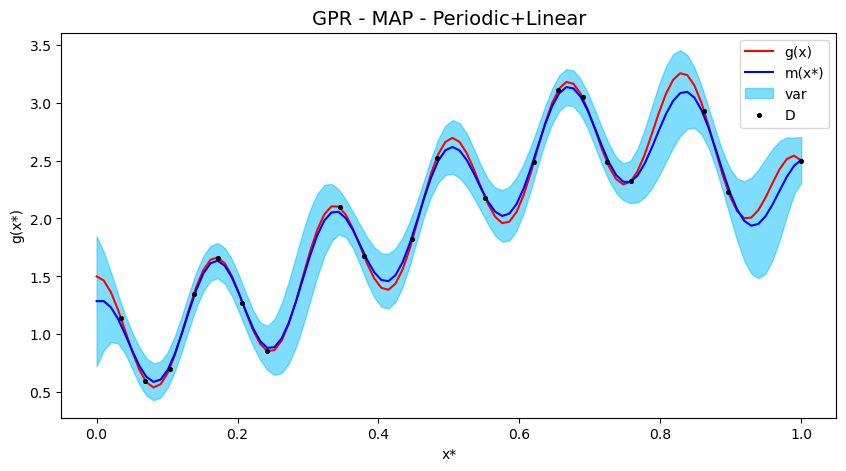

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure all tensors are in the same dtype
dtype = torch.float64  # Using float64 for higher precision
X = X.type(dtype)
y = y.type(dtype)

# Generate new X values for plotting in the same dtype
Xnew = torch.linspace(0, 1, 100, dtype=dtype)

# Get the predictive mean and variance
with torch.no_grad():
    mean, variance = gpr(Xnew, full_cov=False)

# Convert to numpy for plotting, detach tensors that require grad
Xnew_np = Xnew.detach().numpy()
mean_np = mean.detach().numpy()  # Detach before converting to numpy
variance_np = variance.detach().numpy()  # Detach before converting to numpy

# Assuming X_train and y_train are part of your training data and already in the correct dtype
X_train_np = X_train.detach().numpy()
y_train_np = y_train.detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(Xnew_np, func(torch.tensor(Xnew_np, dtype=dtype)).numpy(), label='g(x)', color='red')

plt.plot(Xnew_np, mean_np, label='m(x*)', color='blue')
plt.fill_between(Xnew_np, mean_np + 2*np.sqrt(variance_np), mean_np - 2*np.sqrt(variance_np), color="deepskyblue", alpha=0.5, label='var')
plt.scatter(X_train_np, y_train_np, label='D', color='black', s=7, zorder=3)
plt.xlabel("x*")
plt.ylabel("g(x*)")
plt.legend()
plt.title("GPR - MAP - Periodic+Linear", fontsize=14)
plt.show()
